# Notebook 3: **Clustering-Based Recommender System**

Welcome to the third notebook of our project for AlgorithmArcade Inc. In this notebook, we will develop a clustering-based recommender system using the KMeans algorithm. This approach groups users based on their preferences and recommends courses popular within their cluster.

## **Table of Contents**

1. **Introduction**
2. **Import Libraries**
3. **Load Data**
4. **Preprocessing**
   * Build User Profiles
5. **Clustering Users with KMeans**
   * Determine Optimal Number of Clusters
   * Apply KMeans Clustering
6. **Analyze Clusters**
7. **Generate Recommendations**
8. **Results and Evaluation**
9. **Conclusion**
10. **Thanks and Contact Information**

## 1. **Introduction**

Clustering-based recommender systems group similar users together to make recommendations based on group preferences. By clustering users, we can capture community trends and recommend courses popular among users with similar interests.

In this notebook, we’ll:
   * Build user profiles based on their interactions.
   * Use KMeans clustering to group users.
   * Generate recommendations for users based on their cluster.

## 2. **Import Libraries**

First, let’s import the necessary Python libraries.

In [1]:
# Data manipulation libraries
import pandas as pd
import numpy as np

# Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Dimensionality reduction
from sklearn.decomposition import PCA

# Evaluatio
from sklearn.metrics import silhouette_score

# For progress bars
from tqdm import tqdm

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# For displaying visuals in higher resolution
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set consistent color palette
sns.set_palette('Blues_d')

## 3. **Load Data**

We will load the datasets from the data folder.

In [2]:
# Load user rating data
user_ratings = pd.read_csv('../Data/user_rating_info.csv')

# Load course information data
course_info = pd.read_csv('../Data/course_info.csv')

## 4. **Preprocessing**

We need to prepare the data for clustering.

## 4.1. Build User Profiles

Merge user_ratings with course_info to have course topics for each user interaction.

In [3]:
# Ensure topic columns are integers
topic_columns = ['data_analysis', 'data_science', 'data_engineering',
                 'data_visualization', 'business_intelligence',
                 'artificial_intelligence', 'cloud_computing']

for col in topic_columns:
    course_info[col] = course_info[col].astype(int)

# Merge user ratings with course topics
user_data = pd.merge(user_ratings, course_info[['course_id'] + topic_columns], on='course_id')

Aggregate the topics for each user to create a profile.

In [4]:
# Initialize an empty DataFrame for user profiles
user_profiles = pd.DataFrame(0, index=user_ratings['user_id'].unique(), columns=topic_columns)

# Build user profiles
for user in tqdm(user_profiles.index):
    # Get the topics of courses rated by the user
    user_courses = user_data[user_data['user_id'] == user]
    
    # Weight the topics by the ratings
    for topic in topic_columns:
        user_profiles.loc[user, topic] = (user_courses[topic] * user_courses['rating']).sum()
        
# Normalize the user profiles
user_profiles_normalized = StandardScaler().fit_transform(user_profiles)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2338/2338 [00:02<00:00, 1031.97it/s]


**Note**: We weight the topics by the ratings to give more importance to higher-rated courses.

## 5. **Clustering Users with KMeans**

### 5.1 Determine Optimal Number of Clusters

We will use the Elbow Method to find the optimal number of clusters.

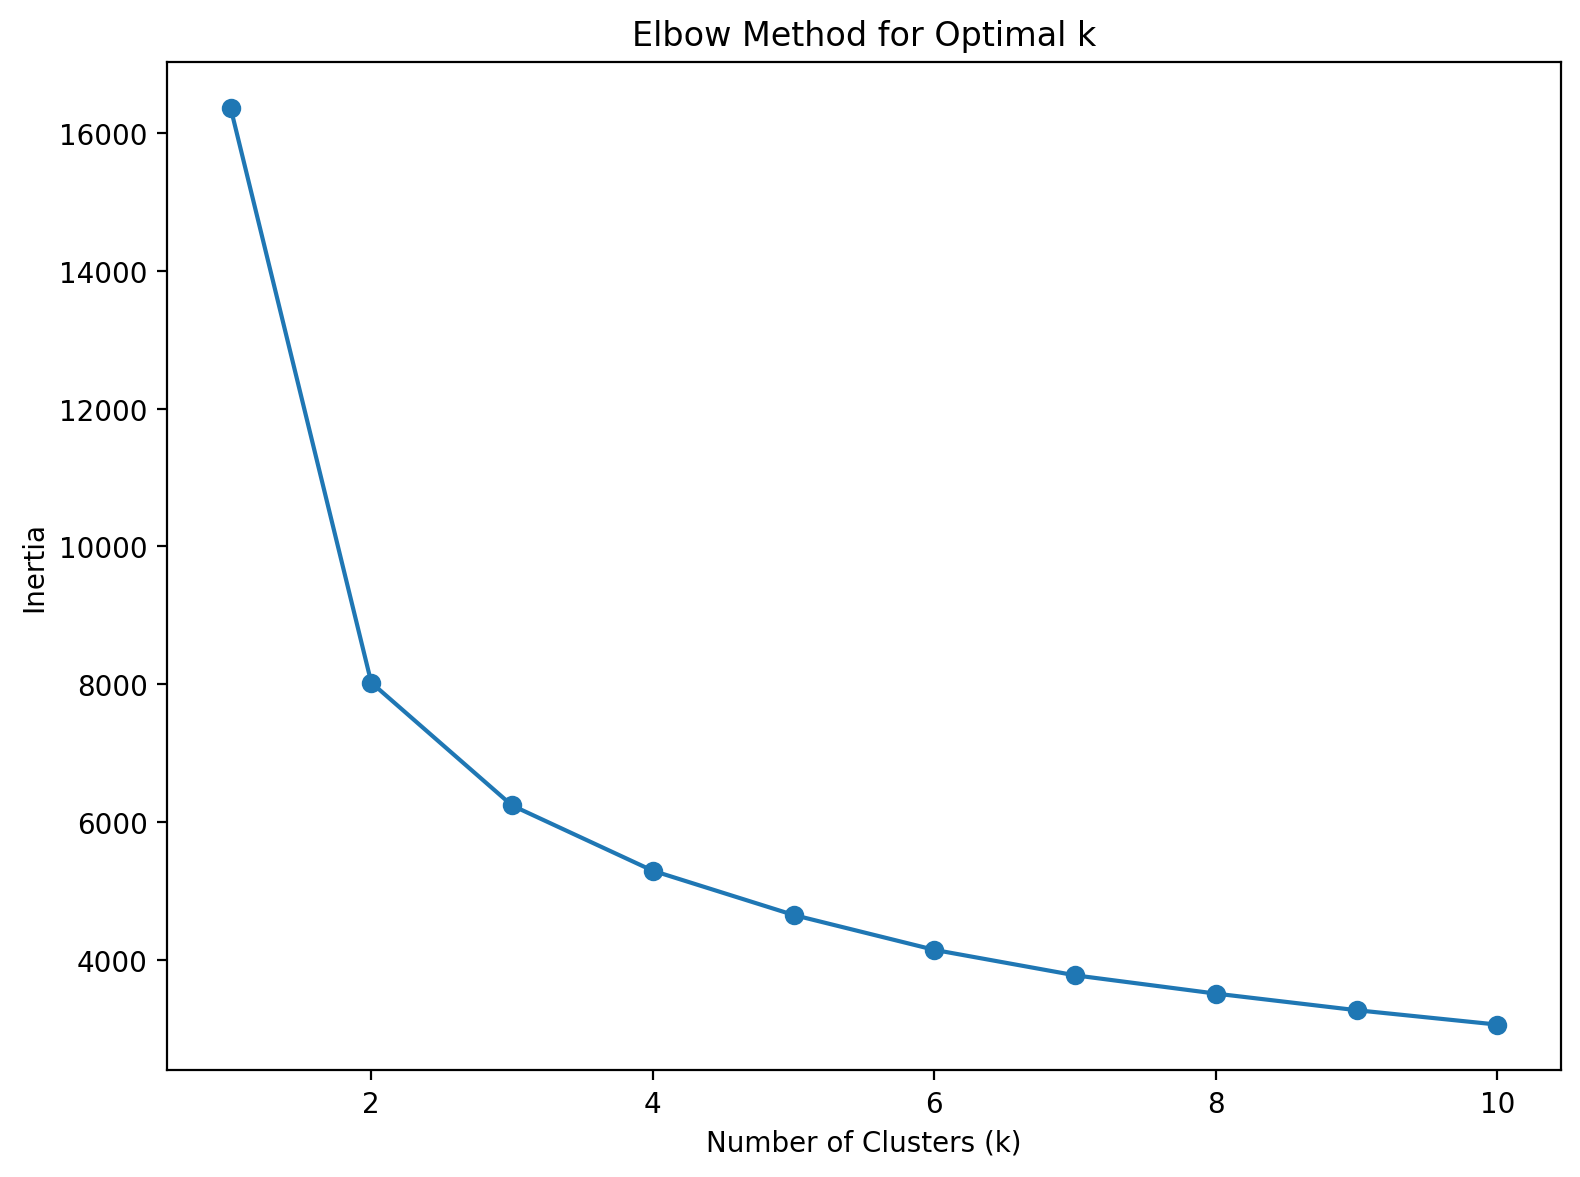

In [5]:
# Range of clusters to try
k_values = range(1, 11)
inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(user_profiles_normalized)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, 'bo-', color="tab:blue")
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.tight_layout()
plt.show()

**Note**: The elbow appears to occur at *k* = **3**

### 5.2 Apply KMeans Clustering

Apply KMeans with the chosen number of clusters.

In [6]:
# Apply KMeans clustering
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
user_clusters = kmeans.fit_predict(user_profiles_normalized)

# Add cluster labels to user profiles
user_profiles['cluster'] = user_clusters

Visualize the clusters using PCA.

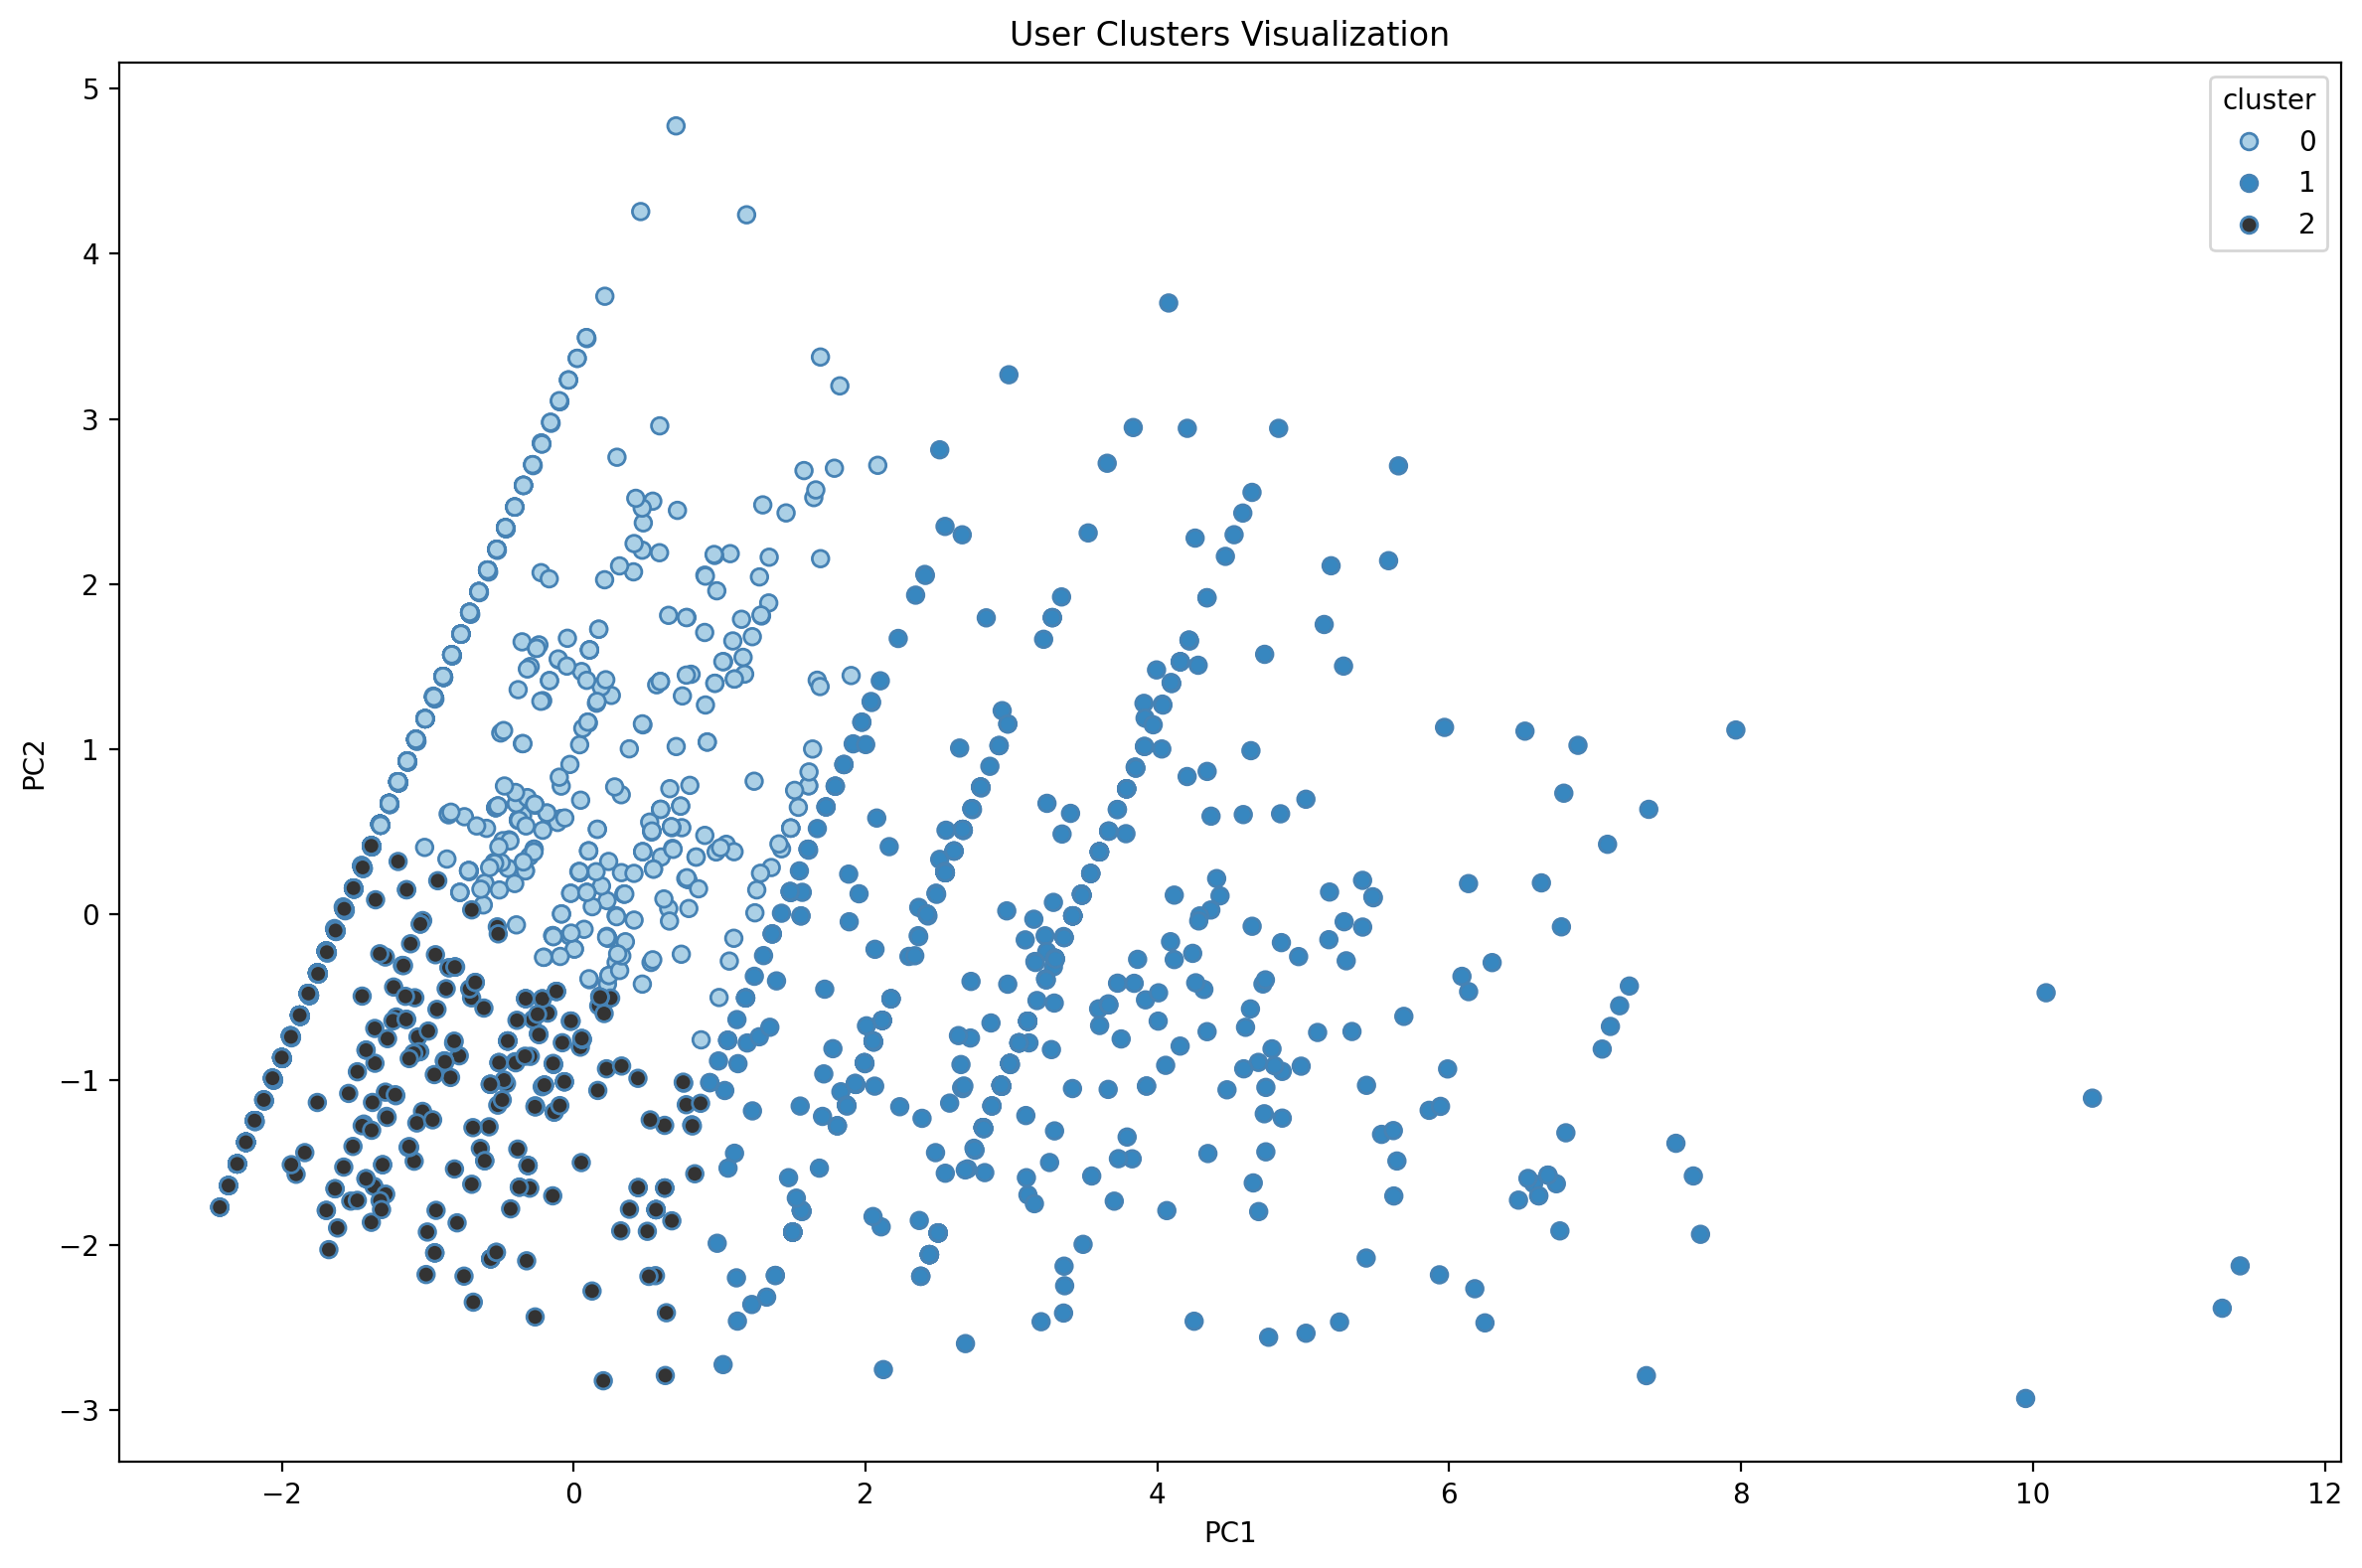

In [7]:
# Reduce dimensions for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(user_profiles_normalized)

# Create a DataFrame for visualization
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['cluster'] = user_clusters

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='Blues_d', linewidth=1, edgecolor='steelblue')
plt.title('User Clusters Visualization')
plt.tight_layout()
plt.show()

## 6. **Analyze Clusters**

Let’s analyze the characteristics of each cluster.

In [8]:
# Group user profiles by cluster and compute the mean
cluster_profiles = user_profiles.groupby('cluster')[topic_columns].mean()

print("Cluster Profiles:")
display(cluster_profiles)

Cluster Profiles:


,data_analysis,data_science,data_engineering,data_visualization,business_intelligence,artificial_intelligence,cloud_computing
cluster,,,,,,,
0,0.254305,10.745695,0.912583,0.279470,0.801325,14.610596,0.870199
1,4.572426,11.808028,5.382199,4.541012,5.368237,15.378709,5.429319
2,0.221782,3.546535,0.416832,0.287129,0.469307,7.324752,0.451485


**Note**: Each cluster’s profile shows the average weighted importance of each topic.

## 7. **Generate Recommendations**

We will generate recommendations for each user based on popular courses within their cluster.

For each cluster, identify the top-rated courses by users in the cluster.

In [9]:
# Merge user ratings with cluster labels
user_ratings_clusters = pd.merge(user_ratings, user_profiles[['cluster']], left_on='user_id', right_index=True)

# Function to get top courses for a cluster
def get_top_courses(cluster_label, n=10):
    # Get users in the cluster
    cluster_users = user_ratings_clusters[user_ratings_clusters['cluster'] == cluster_label]
    # Compute average ratings for each course
    course_ratings = cluster_users.groupby('course_id')['rating'].mean()
    # Get courses with the highest average ratings
    top_courses = course_ratings.sort_values(ascending=False).head(n)
    return top_courses.index.tolist()

# Dictionary to store top courses for each cluster
cluster_top_courses = {}
for cluster in user_profiles['cluster'].unique():
    cluster_top_courses[cluster] = get_top_courses(cluster)

Recommend these courses to users in the cluster who haven’t taken them yet.

In [10]:
# Dictionary to store recommendations
user_recommendations_cluster = {}

for user in tqdm(user_profiles.index):
    # Get user's cluster
    cluster_label = user_profiles.loc[user, 'cluster']
    # Get top courses for the cluster
    top_courses = cluster_top_courses[cluster_label]
    # Get courses the user has already interacted with
    user_courses = user_ratings[user_ratings['user_id'] == user]['course_id'].tolist()
    # Recommend courses not yet taken by the user
    recommendations = [course for course in top_courses if course not in user_courses]
    user_recommendations_cluster[user] = recommendations[:10]  # Limit to top 10 recommendations

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2338/2338 [00:00<00:00, 3245.38it/s]


**Example Recommendations for a User:**

In [11]:
# Example: Recommendations for a specific user
user_id_example = user_profiles.index[0]
cluster_example = user_profiles[user_profiles.index == user_id_example]['cluster'].values[0]
recommended_courses_cluster = user_recommendations_cluster[user_id_example]

# Get course titles
recommended_titles_cluster = course_info[course_info['course_id'].isin(recommended_courses_cluster)]['title']
print(f"Top recommendations for {user_id_example} of Cluster {cluster_example}:\n")
[print(title) for title in recommended_titles_cluster.tolist()]

Top recommendations for UID0001293 of Cluster 1:

Data Cleaning Techniques: Preparing Data for Analysis
BI Reporting Tools Expertise: Mastering BI Software
Serverless Computing: Building Applications Without Servers
AI-Driven Chatbots: Enhancing Customer Engagement
Cloud Resource Provisioning: Automating Cloud Infrastructure
Sentiment Analysis with AI: Gauging Public Opinion
Reinforcement Learning in Robotics: Teaching Machines to Act
Data Governance Implementation: Policies and Practices
Statistical Inference: Drawing Conclusions from Data
Network Analysis: Exploring Relationships in Data


[None, None, None, None, None, None, None, None, None, None]

## 8. **Results and Evaluation**

#### **Analysis**:

   * Users receive recommendations of courses popular among similar users.
   * The recommendations may help users discover new courses relevant to their interests.

#### **Advantages**:

   * Captures group preferences, which can be useful when individual data is sparse.
   * May uncover courses the user wasn’t aware of but are popular in their community.

#### **Limitations**:

   * Assumes users in the same cluster have similar preferences in all aspects.
   * May not account for unique preferences within clusters.

#### **Evaluation Metrics**:

In [12]:
sil_score = silhouette_score(user_profiles_normalized, user_clusters)
print(f"Silhouette Score for k={optimal_k}: {sil_score:.2f}")

Silhouette Score for k=3: 0.37


**Note**: A silhouette Score of **0.37** indicates a **decent** clustering.

## 9. **Conclusion**

In this notebook, we developed a clustering-based recommender system using KMeans. By grouping users based on their preferences, we can recommend courses that are popular among their peers.

## 10. **Thanks and Contact Information**

Thank you for reviewing this project notebook. For any further questions, suggestions, or collaborations, please feel free to reach out:

   * [**Email**](mailto:leejoabraham01@gmail.com)
   * [**LinkedIn**](https://www.linkedin.com/in/leejoabraham01)
   * [**GitHub**](https://github.com/LeejoAbraham01)